In [33]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted, check_array
import numpy as np

class ExponentialSaturation(BaseEstimator, TransformerMixin):
    def __init__(self, a=1.):
        self.a = a
        
    def fit(self, X, y=None):
        X = check_array(X)
        self._check_n_features(X, reset=True) # from BaseEstimator
        return self

    def transform(self, X):
        check_is_fitted(self)
        X = check_array(X)
        self._check_n_features(X, reset=False) # from BaseEstimator
        return 1 - np.exp(-self.a*X)

In [34]:
from scipy.signal import convolve2d

class ExponentialCarryover(BaseEstimator, TransformerMixin):
    def __init__(self, strength=0.5, length=1):
        self.strength = strength
        self.length = length

    def fit(self, X, y=None):
        X = check_array(X)
        self._check_n_features(X, reset=True)
        self.sliding_window_ = (
            self.strength ** np.arange(self.length + 1)
        ).reshape(-1, 1)
        return self

    def transform(self, X: np.ndarray):
        check_is_fitted(self)
        X = check_array(X)
        self._check_n_features(X, reset=False)
        convolution = convolve2d(X, self.sliding_window_)
        if self.length > 0:
            convolution = convolution[: -self.length]
        return convolution

In [35]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

adstock = ColumnTransformer(
    [
     ('facebook_pipe', Pipeline([
                           ('carryover', ExponentialCarryover()),
                           ('saturation', ExponentialSaturation())
     ]), ['facebook']),
     ('google_pipe', Pipeline([
                           ('carryover', ExponentialCarryover()),
                           ('saturation', ExponentialSaturation())
     ]), ['google'])
    ],
    remainder='passthrough'
)

model = Pipeline([
                  ('adstock', adstock),
                  ('regression', LinearRegression())
])

In [65]:
import pandas as pd

df = pd.read_csv('../raw_data/df_clean.csv')
df = df.drop(columns='Unnamed: 0')
df['Day'] = pd.to_datetime(df['Day'])
df.set_index('Day', inplace=True)
df = df.rename(columns={"fb_costs": "facebook", "google_costs": "google", "tt_costs": "tiktok"})

# create a simple dataframe

simple_df = df.drop(columns = ['fb_impressions', 'fb_clicks', 'google_impressions', 'google_clicks', 'tt_impressions', 'tt_clicks'])

X_simple = simple_df.drop(columns = ['orders', 'total_sales']) # 2 channels: facebook and google
y_simple = simple_df['total_sales'] # for now lets just use total_sales and exclude orders

In [54]:
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

model.fit(X_simple, y_simple)

cross_val_score(model, X_simple, y_simple, cv=TimeSeriesSplit()).mean()

-0.23191432831681374

In [64]:
model.fit(X_simple, y_simple).score(X_simple, y_simple)

0.15595412338052106

In [55]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

tuned_model = RandomizedSearchCV(
    estimator=model,
    param_distributions={
        'adstock__facebook_pipe__carryover__strength': uniform(0, 1),
        'adstock__facebook_pipe__carryover__length': randint(0, 6),
        'adstock__facebook_pipe__saturation__a': uniform(0, 0.01),
        'adstock__google_pipe__carryover__strength': uniform(0, 1),
        'adstock__google_pipe__carryover__length': randint(0, 6),
        'adstock__google_pipe__saturation__a': uniform(0, 0.01),
    },
    n_iter=100,
    cv=TimeSeriesSplit()
)

In [56]:
cross_val_score(tuned_model, X_simple, y_simple, cv=TimeSeriesSplit()).mean()

-0.43394663936940103

In [57]:
tuned_model.fit(X_simple, y_simple)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('adstock',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('facebook_pipe',
                                                                               Pipeline(steps=[('carryover',
                                                                                                ExponentialCarryover()),
                                                                                               ('saturation',
                                                                                                ExponentialSaturation())]),
                                                                               ['facebook']),
                                                                              ('google_pipe',
                                                                               Pipeline(steps=[('carryove...
                                        'adstock__google_pipe__carryover__length': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1129313f0>,
                                        'adstock__google_pipe__carryover__strength': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x112932830>,
                                        'adstock__google_pipe__saturation__a': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x112932440>})

# Visualization

In [61]:
y

,total_sales
Day,
2021-07-01,414.85
2021-07-02,229.95
2021-07-03,459.89
2021-07-04,508.36
2021-07-05,399.88
...,...
2020-07-29,0.00
2020-07-28,0.00
2020-07-27,0.00


ValueError: When stacked is True, each column must be either all positive or all negative. Column 'Base' contains both positive and negative values

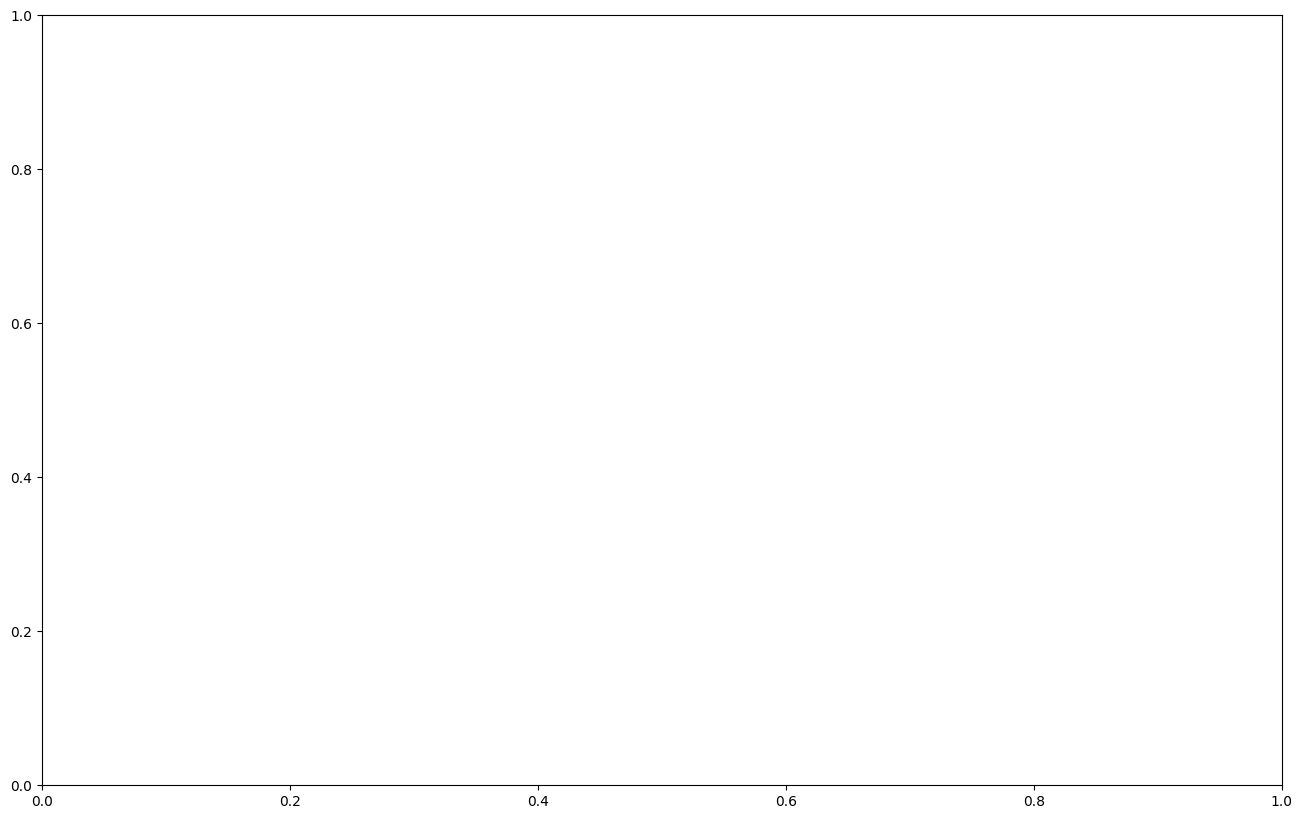

In [63]:
adstock_data = pd.DataFrame(
    tuned_model.best_estimator_.named_steps['adstock'].transform(X_simple),
    columns=X_simple.columns,
    index=X_simple.index
)

weights = pd.Series(
    tuned_model.best_estimator_.named_steps['regression'].coef_[0],
    index=X_simple.columns
)

y = simple_df[['total_sales']]

base = tuned_model.best_estimator_.named_steps['regression'].intercept_

unadj_contributions = adstock_data.mul(weights).assign(Base=base)
adj_contributions = (unadj_contributions
                     .div(unadj_contributions.sum(axis=1), axis=0)
                     .mul(y['total_sales'], axis=0)
                    )

ax = (adj_contributions[['Base', 'facebook', 'google']]
      .plot.area(
          figsize=(16, 10),
          linewidth=1,
          title='Predicted Sales and Breakdown',
          ylabel='Sales',
          xlabel='Date'
      )
     )
    
handles, labels = ax.get_legend_handles_labels()

ax.legend(
    handles[::-1], labels[::-1],
    title='Channels', loc="center left",
    bbox_to_anchor=(1.01, 0.5)
)